# 3. Метрики и подбор гиперпараметров

In [2]:
import numpy as np
from setup_libs import *

Итак, нам надо выбрать такое пространство алгоритмов $\mathbb{A}$ и функционал минимизации $Q(a, X_{train}, y_{train})$, чтобы решать задачу машинного обучения:

$$a(x) = argmin_{a \in \mathbb{A}}Q(a, X_{train}, y_{train})$$

Обычно алгоритм сам знает какой функционал ему минимизировать, либо мы можем его поменять в гиперпараметрах алгоритма.

Однако, в данных могут случаться `шумы` и `выбросы`. Формально корректное решение уравнения выше, может привести к `переобучению`. 

Чтобы избежать данной проблемы необходимо искусственно ограничивать пространство допустимых алгоритмов с помощью гиперпараметров (например: `максимальную глубину дерева` в дереве решений).

# Как выбрать наилучшие гиперпараметры?

## Кросс-валидация

<img src=https://i.stack.imgur.com/YWgro.gif>

`Идея`: разобъем нашу выборку на 5 равнозначных частей. Одну часть - сделаем тестовой выборкой, а оставшееся оставим в тренировочной выборке. Таким образом мы получим 5 комбинаций тренировочных и тестовых выборок. 

А теперь обучим наш алгоритм 5 раз на разных выборках и посмотрим `насколько хорошо` предсказывает наш алгоритм результат для разных выборок.

В случае классификации под `настолько хорошо` будем обозначать **долю правильных ответов** (`accuracy`). А вообще это целая большая тема под названием `Метрики`, которой мы займемся в следующий раз.

In [3]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris

iris = load_iris()

clf_1 = DecisionTreeClassifier(max_depth=2)
clf_2 = DecisionTreeClassifier(max_depth=3)

accuracies1 = cross_val_score(clf_1, X = iris.data, y=iris.target, cv=5)
accuracies2 = cross_val_score(clf_2, X = iris.data, y=iris.target, cv=5)

In [4]:
accuracies1.mean(), accuracies2.mean()

(np.float64(0.9333333333333332), np.float64(0.96))

Получаем, что в среднем более глубокое дерево для Iris, работает лучше.

А вообще можно взять и перебрать все значения гиперпараметра, чтобы найти наилучший результат.

## GridSearch

Перебираем значения параметра и считаем `результат` для классификатора. 

`Результат` - среднее значение кроссвалидации.

In [5]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.datasets import load_iris # в sklearn есть встроенные датасеты

iris=load_iris()
params = {'max_depth': [2, 4, 8]}

gs = GridSearchCV(
        estimator = DTC(), #классификатор
        param_grid = params, # передираемый параметр
        cv = 5, #кросс-валидация
        scoring = 'accuracy' #результат - доля правильных ответов
    )

In [6]:
gs.fit(iris.data, iris.target)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [2, 4, 8]}, scoring='accuracy')

In [7]:
pd.DataFrame.from_dict(gs.cv_results_).sort_values(by='rank_test_score').head(4)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,0.000413,0.000015,0.000400,0.000007,4,{'max_depth': 4},0.966667,0.966667,0.9,0.966667,1.0,0.960000,0.032660,1
2,0.000411,0.000015,0.000387,0.000020,8,{'max_depth': 8},0.966667,0.966667,0.9,0.933333,1.0,0.953333,0.033993,2
0,0.000474,0.000109,0.000429,0.000042,2,{'max_depth': 2},0.933333,0.966667,0.9,0.866667,1.0,0.933333,0.047140,3


## Random Search
![title](https://i.stack.imgur.com/cIDuR.png)

`GridSearch` - это честный перебор всех параметров, который может оказаться очень долгим. На самом деле можно двигаться гораздо быстрее с помощью RandomizedSearch.
Алгоритм:
* Выбираем рандомную точку $x$ в пространстве заданных параметров
* Пока не кончится количество итераций(заданное заранее)
  * Выбираем новую точку $y$ c помощью 
  * Если $f(y) < f(x)$, то x = y

In [8]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import load_iris # в sklearn есть встроенные датасеты

iris=load_iris()
params = {'max_depth': np.arange(1, 11)}

rs = RandomizedSearchCV(
        n_iter = 100,
        estimator = DTC(), #классификатор
        param_distributions = params, # передираемый параметр
        cv = 5, #кросс-валидация
        scoring = 'accuracy' #результат - доля правильных ответов
    )
rs.fit(iris.data, iris.target)

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_iter=100,
                   param_distributions={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])},
                   scoring='accuracy')

In [9]:
pd.DataFrame(rs.cv_results_).sort_values(by='rank_test_score').head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,0.000443,0.000042,0.000430,0.000099,6,{'max_depth': 6},0.966667,0.966667,0.9,1.000000,1.0,0.966667,0.036515,1
4,0.000385,0.000028,0.000366,0.000009,5,{'max_depth': 5},0.966667,0.966667,0.9,1.000000,1.0,0.966667,0.036515,1
6,0.000361,0.000009,0.000337,0.000007,7,{'max_depth': 7},0.966667,0.966667,0.9,0.966667,1.0,0.960000,0.032660,3


Обычно `RandomSearch` работает хуже, но гораздо быстрее `GridSearch`, поэтому тут ваш выбор: либо точный результат, либо скорость.

Получили наилучшую глубину дерева - 3. С результатом 0.973333

## [Hyperopt](https://github.com/hyperopt/hyperopt), [Optuna](https://github.com/optuna/optuna)

Попытки использовать Байесовскую оптимизацию и прочую чёрную магию для тюнинга гиперпараметров

100%|██████████| 100/100 [00:00<00:00, 1442.23trial/s, best loss: -1.1754445092638273]
{'x': np.float64(5.048439681397176)}


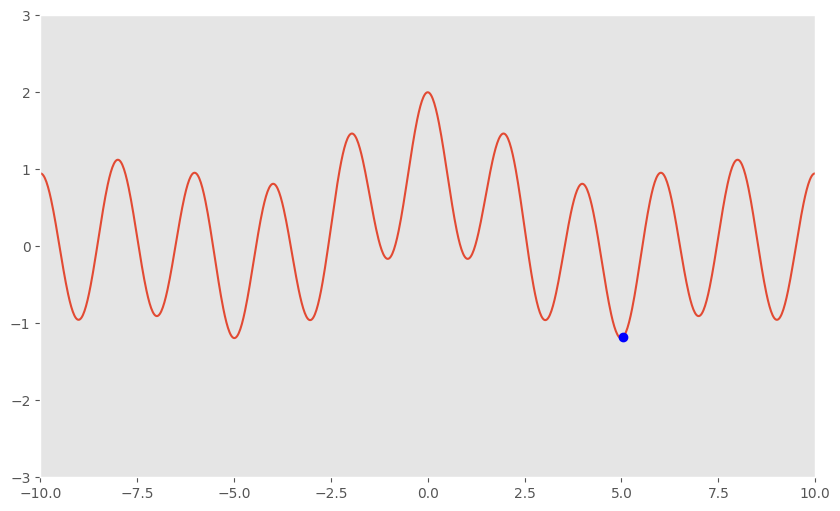

In [10]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

def func_to_optimize(x):
    return np.sin(x)/x + np.cos(np.pi*x)

best = fmin(
    fn=func_to_optimize ,
    space=hp.uniform('x', -10, 10),
    algo=tpe.suggest,
    max_evals=100)

print(best)
x = np.linspace(-10,10,1000)
y = func_to_optimize(x)
plt.figure()
plt.plot(x, y)
plt.plot(best['x'], func_to_optimize(best['x']), 'bo')
plt.xlim([-10, 10])
plt.ylim([-3, 3])
plt.grid()
plt.show()

### Hyperopt и KNN 

In [11]:
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier


iris = datasets.load_iris()
X = iris.data
y = iris.target

def hyperopt_train_test(params):
    clf = KNeighborsClassifier(**params)
    return cross_val_score(clf, X, y).mean()


space4knn = {
    'n_neighbors': hp.choice('n_neighbors', range(1,100))
}

def f(params):
    acc = hyperopt_train_test(params)
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, space4knn, algo=tpe.suggest, max_evals=100, trials=trials)

print('best:')
print(best)


100%|██████████| 100/100 [00:01<00:00, 84.97trial/s, best loss: -0.9800000000000001]
best:
{'n_neighbors': np.int64(5)}


### Hyperopt и деревья

In [12]:
from hyperopt import fmin, tpe, hp, Trials
from sklearn.datasets import load_iris # в sklearn есть встроенные датасеты

iris = load_iris()
X = iris.data
y = iris.target

def hyperopt_train_test(params):
    X_ = X[:]
    clf = DecisionTreeClassifier(**params)
    return cross_val_score(clf, X, y).mean()

space4dt = {
    'max_depth': hp.choice('max_depth', range(1,20)),
    'max_features': hp.choice('max_features', range(1,5)),
    'criterion': hp.choice('criterion', ["gini", "entropy"]),
}

def f(params):
    acc = hyperopt_train_test(params)
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, space4dt, algo=tpe.suggest, max_evals=300, trials=trials)

print('best:')
print(best)

100%|██████████| 300/300 [00:02<00:00, 148.54trial/s, best loss: -0.9733333333333334]
best:
{'criterion': np.int64(0), 'max_depth': np.int64(2), 'max_features': np.int64(2)}


# Метрики классификации

## Матрица ошибок. Двухклассовая классификация
- $TP$ = кол-во пар, где: $y_{predicted} = 1$, $y_{real} = 1$
- $FP$ = кол-во пар, где: $y_{predicted} = 1$, $y_{real} = 0$ (ошибки первого рода)
- $TN$ = кол-во пар, где: $y_{predicted} = 0$, $y_{real} = 0$
- $FN$ = кол-во пар, где: $y_{predicted} = 0$, $y_{real} = 1$ (ошибки второго рода)

Первая буква - совпадает ли реальность с классификацией. Вторая - Что выдал классификатор.


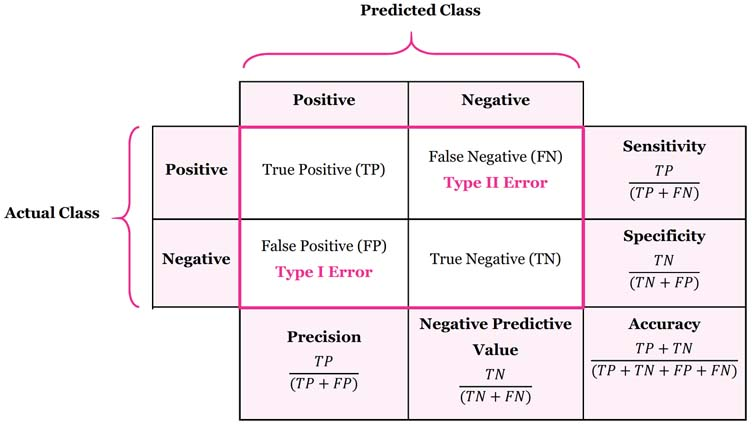

In [13]:
Image('images/confusionMatrxiUpdated.jpg')

In [14]:
y_real = np.array([0, 1, 0, 0, 1, 1, 1, 1])
y_pred = np.array([0, 1, 1, 0, 1, 1, 0, 0])

M = metrics.confusion_matrix(y_real, y_pred)
M

array([[2, 1],
       [2, 3]])

## Характеристики бинарного классификатора

$$accuracy = ACC = \frac{TP + TN}{TP + TN + FP + FN}$$

$$recall = TPR = \frac{TP}{TP + FN},\quad SPC = \frac{TN}{TN + FP}$$

$$precision = PPV = \frac{TP}{TP + FP},\quad FPR= \frac{FP}{TN + FP},$$

$$F_1 = 2\frac{precision\cdot recall}{precision + recall}, \quad F_{\beta} = (1 + \beta^2)\frac{precision\cdot recall}{\beta^2precision + recall}$$

$ACC$ (`Accuracy`) - доля верно классифицированных примеров среди всех примеров. Основная характеристика качества классификации.

$TPR$ (True positive rate, `recall`, `полнота`) - доля верно классифицированных положительных примеров среди всех положительных примеров.

$SPC$ (Specificity, true negative rate) - доля верно классифицированных отрицательных примеров среди всех отрицательных примеров.

$PPV$ (Positive predictive value, `precision`, `точность`) - доля верно классифицированных положительных примеров среди всех примеров, классифицированных положительно.

$FPR$ (False positive rate) - доля ошибочно классифицированных отрицательных примеров среди всех отрицательных примеров.

$F_1$ (F1-measure) - среднее гармоническое точности и полноты. Позволяет учесть обе характеристики одновременно.


$F_{beta}$ (Fbeta-measure) - $F_1$ c возможностью контролировать важность точности или полноты относительно друг друга.

Подробно про метрики классификации можно почитать [тут](https://alexanderdyakonov.wordpress.com/2019/05/31/%D1%84%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D0%BE%D0%BD%D0%B0%D0%BB%D1%8B-%D0%BA%D0%B0%D1%87%D0%B5%D1%81%D1%82%D0%B2%D0%B0-%D0%B2-%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%D0%B5-%D0%B1%D0%B8%D0%BD%D0%B0%D1%80%D0%BD/), а про метрики регрессии [тут](https://alexanderdyakonov.wordpress.com/2018/10/23/%D1%84%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D0%B8-%D0%BE%D1%88%D0%B8%D0%B1%D0%BE%D0%BA-%D0%B2-%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%D0%B0%D1%85-%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D0%B8/)



In [15]:
accuracy = metrics.accuracy_score(y_real, y_pred)
recall = metrics.recall_score(y_real, y_pred)
precision = metrics.precision_score(y_real, y_pred)
f1 = metrics.f1_score(y_real, y_pred)
fb = metrics.fbeta_score(y_real, y_pred, beta=2)
print('accuracy: {}'.format(accuracy))
print('recall: {}'.format(recall))
print('precision: {}'.format(precision))
print('F1: {}'.format(f1))
print('Fb: {}'.format(fb))

accuracy: 0.625
recall: 0.6
precision: 0.75
F1: 0.6666666666666666
Fb: 0.625


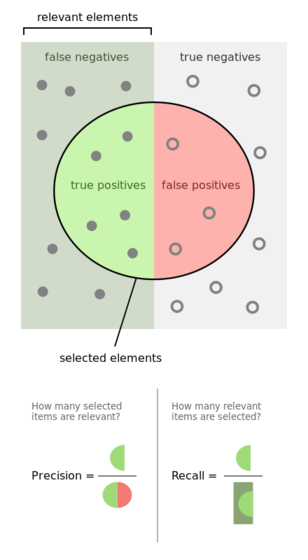

In [16]:
Image('images/precall.png')

## Другие материки качества
Существует еще много других метрик для бинарной классификации, например

$$NegLogLoss = -\frac{1}{n}\sum_{i=1}^{l}(y_{real}^{(i)}\log(p_{pred}^{(i)}) + (1-y_{real}^{(i)})\log(1-p_{pred}^{(i)}))$$

$$brierloss = \sum_{i=1}^{n}(y_{real}^{(i)} - y_{pred}^{(i)})^2$$

Выбирать метрику нужно **исходя из задачи**, ведь каждая работает по своему и находит свое лучшее решение.

Логлосс например учитывает доли правильных и неправильных ответов, но сильно штрафует за уверенность классификатора в неверном ответе.

In [17]:
y_real = np.array([0,     1,   0,     0,    1,   1,   1,   1])
p_pred = np.array([0.1, 0.9, 0.5, 0.001, 0.95, 0.9, 0.1, 0.2])

print(metrics.log_loss(y_real, p_pred))
-np.mean(y_real * np.log(p_pred) + (1-y_real) * np.log(1 - p_pred))

0.621693190960338


np.float64(0.621693190960338)

### Пример. Наша самодельная классификация

In [18]:
from sklearn.model_selection import train_test_split
np.random.seed(1337)
n = 1000
a = np.random.normal(loc=0, scale=0.7, size=(n, 2)) #первый класс
b = np.random.normal(loc=1, scale=0.7, size=(n, 2)) #второй класс
X = np.vstack([a, b]) #двумерный количественный признак
y = np.hstack([np.zeros(n), np.ones(n)]) #бинарный признак

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

(1800, 2) (1800,)


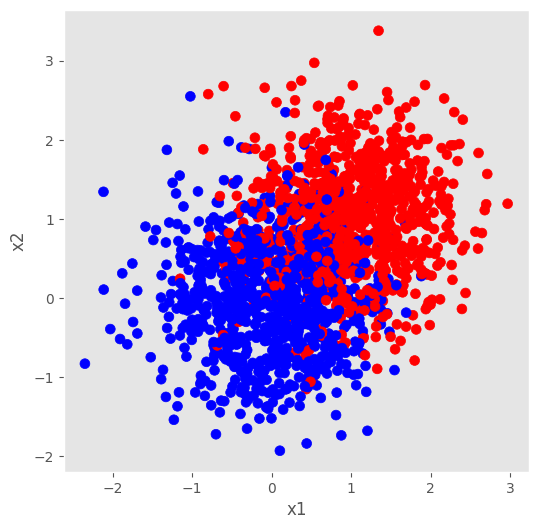

In [19]:
print(X_train.shape, y_train.shape)
plt.figure(figsize=(6, 6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='bwr', s=50, alpha=1)
plt.xlabel('x1')
plt.ylabel('x2')
plt.grid()

In [20]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier as KNN
clf = KNN(10)

И проведем кроссвалидацию по 3-м разным метрикам. В том числе напишем свою. 

In [21]:
acc_score = cross_val_score(clf, X_train, y_train, cv=5, 
                            scoring=metrics._scorer.accuracy_scorer)

nll = cross_val_score(clf, X_train, y_train, cv=5, 
                      scoring=metrics._scorer.neg_log_loss_scorer)

def my_score(y, y_pred):
    return ((y_pred - y)**2).sum()

my_score = cross_val_score(clf, X_train, y_train, cv=5, 
                           scoring=metrics.make_scorer(my_score))

In [22]:
acc_score, nll, my_score

(array([0.825     , 0.8       , 0.81666667, 0.85      , 0.83333333]),
 array([-0.54016588, -1.05387983, -1.31701132, -0.6101144 , -0.81650605]),
 array([63., 72., 66., 54., 60.]))

## [ROC-кривая и AUC](https://towardsdatascience.com/receiver-operating-characteristic-curves-demystified-in-python-bd531a4364d0)

Пусть наш алгоритм предсказывает не только значения, но и **вероятности** получить то или иное значение. Возьмем массив вероятностей получить 1.

In [23]:
model = clf.fit(X_train, y_train)
y_prob = model.predict_proba(X_test)
y_prob1 = y_prob[:,1]

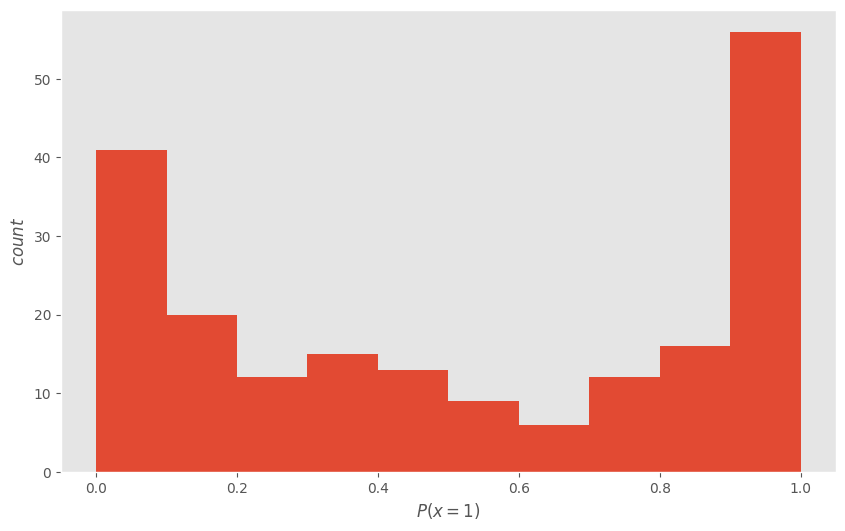

In [24]:
plt.hist(y_prob1, bins=[round(i/10,1) for i in range(11)])
plt.xlabel('$P(x = 1)$')
plt.ylabel('$count$')
plt.grid()

А теперь нарисуем две такие гистограммы, отдельно для объектов класса 0, отдельно для объектов класса 1

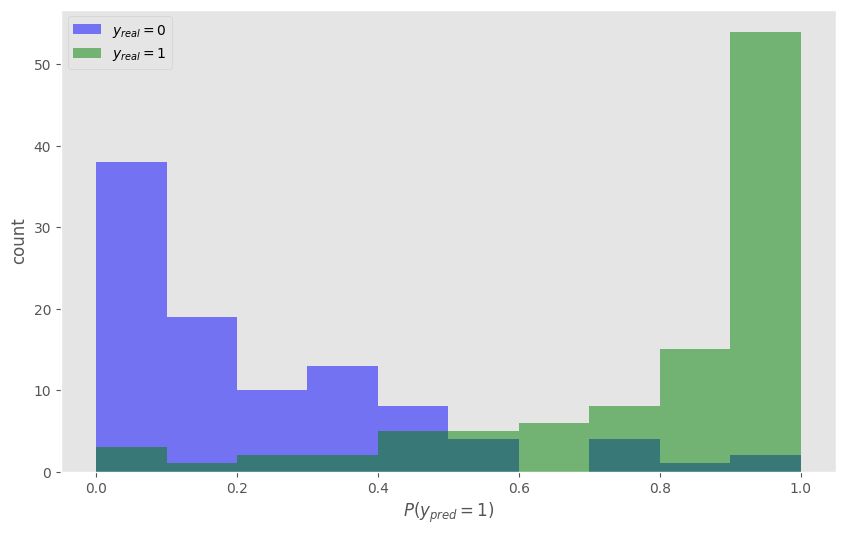

In [25]:
table = np.hstack((y_prob1.reshape((-1,1)), y_test.reshape((-1,1))))
zero_pred = table[table[:,1]==0]
ones_pred = table[table[:,1]==1]
plt.hist(zero_pred[:,0], bins=[round(i/10,1) for i in range(11)], color='blue', alpha=0.5, label='$y_{real}=0$')
plt.hist(ones_pred[:,0], bins=[round(i/10,1) for i in range(11)], color='green', alpha=0.5, label='$y_{real}=1$')
plt.ylabel('count')
plt.xlabel('$P(y_{pred} = 1)$')
plt.legend()
plt.grid()

### ROC-кривая и AUC

**ROC-кривая.** ROC означает `receiver operating characteristic`, как так вышло, и при чём тут приёмник, можно прочесть [тут](https://habr.com/ru/articles/549376/). ROC - кривая это графическая характеристика качества бинарного классификатора, выражающая зависимость `TPR` от `FPR` при варьировании порога решающего правила.



**Порог решающего правила**(`threshold`): при какой вероятности мы присваиваем объекту класс 1.

Мы двигаемся справа налево и считаем `TPR` и `FPR` следующим образом: 
* TP - зеленые справа от порога.
* FP - синие справа от порога.
* TN - синие слева от порога.
* FN - зеленые слева от порога.

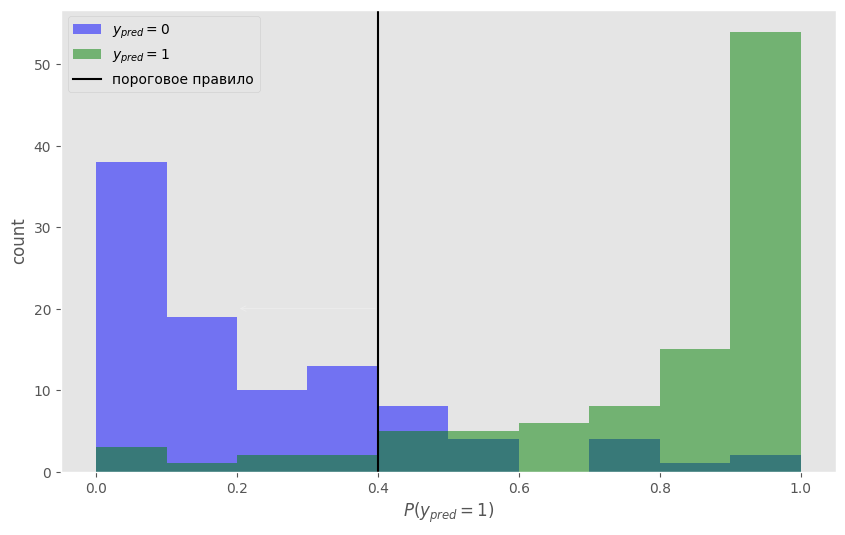

In [26]:
table = np.hstack((y_prob1.reshape((-1,1)), y_test.reshape((-1,1))))
zero_pred = table[table[:,1]==0]
ones_pred = table[table[:,1]==1]
plt.hist(zero_pred[:,0], bins=[round(i/10,1) for i in range(11)], color='blue', alpha=0.5, label='$y_{pred}=0$')
plt.hist(ones_pred[:,0], bins=[round(i/10,1) for i in range(11)], color='green', alpha=0.5, label='$y_{pred}=1$')
plt.axvline(x=0.4, c='black', label='пороговое правило')
plt.annotate("", xy=(0.2, 20), xytext=(0.4, 20), arrowprops=dict(arrowstyle="->"))
plt.ylabel('count')
plt.xlabel('$P(y_{pred} = 1)$')
plt.legend()
plt.grid()

Так пройдя все возможные значения для `TPR` и `FPR` мы получим несколько координат точек, по которым сможем нарисовать ROC-кривую.

Функция, которая за нас все посчитает: 

In [27]:
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob1)

In [28]:
fpr, tpr

(array([0.        , 0.        , 0.02020202, 0.03030303, 0.07070707,
        0.07070707, 0.11111111, 0.19191919, 0.32323232, 0.42424242,
        0.61616162, 1.        ]),
 array([0.        , 0.37623762, 0.53465347, 0.68316832, 0.76237624,
        0.82178218, 0.87128713, 0.92079208, 0.94059406, 0.96039604,
        0.97029703, 1.        ]))

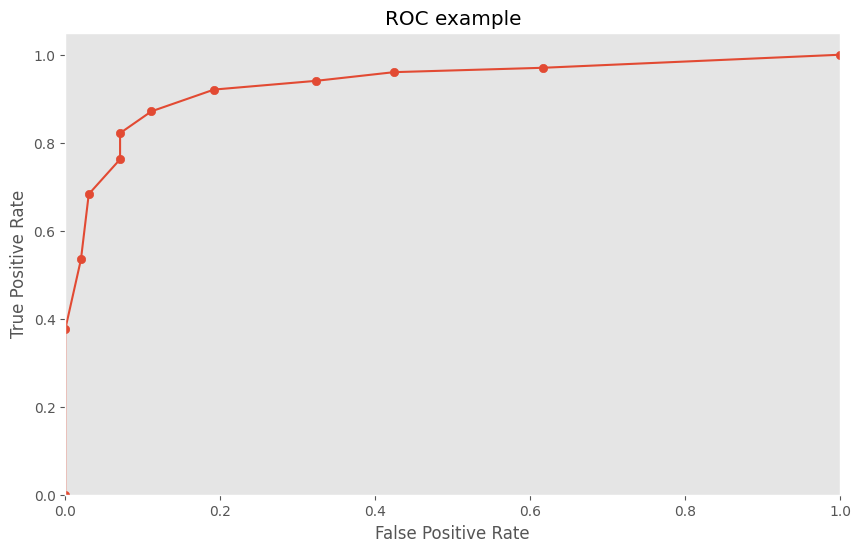

In [29]:
plt.figure()
plt.scatter(fpr, tpr)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC example')
plt.grid()
plt.show()

ROC-кривая проходит через точки (0, 0) и (1, 1) и монотонно не убывает. Чем ближе кривая внутри квадрата $[0, 1]\times[0, 1]$ к левому верхнему углу, тем лучше. Идеальный вариант - кривая, проходящая через три точки: (0, 0), (1, 1) и (0, 1). Диагональ данного квадрата соответствует случайному гаданию.

#### AUC - площадь под графиком ROC. Это важный показатель качества классификации.

Про AUC-ROC хорошо написано [тут](http://dyakonov.org/2017/07/28/auc-roc-площадь-под-кривой-ошибок/), рекомендую

In [30]:
roc_auc = metrics.auc(fpr, tpr)
roc_auc

np.float64(0.9327932793279328)

### А что будет, если у нас классы будут полностью пересекаться?

In [31]:
np.random.seed(1337)
n = 1000
a = np.random.normal(loc=0, scale=0.7, size=(n, 2)) #первый класс
b = np.random.normal(loc=0, scale=0.7, size=(n, 2)) #второй класс
X = np.vstack([a, b]) #двумерный количественный признак
y = np.hstack([np.zeros(n), np.ones(n)]) #бинарный признак

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

(1800, 2) (1800,)


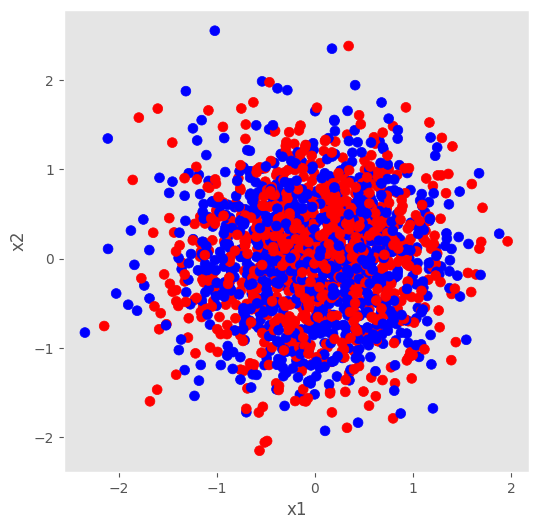

In [32]:
print(X_train.shape, y_train.shape)
plt.figure(figsize=(6, 6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='bwr', s=50, alpha=1)
plt.xlabel('x1')
plt.ylabel('x2')
plt.grid()

In [33]:
model = clf.fit(X_train, y_train)
y_prob = model.predict_proba(X_test)
y_prob1 = y_prob[:,1]

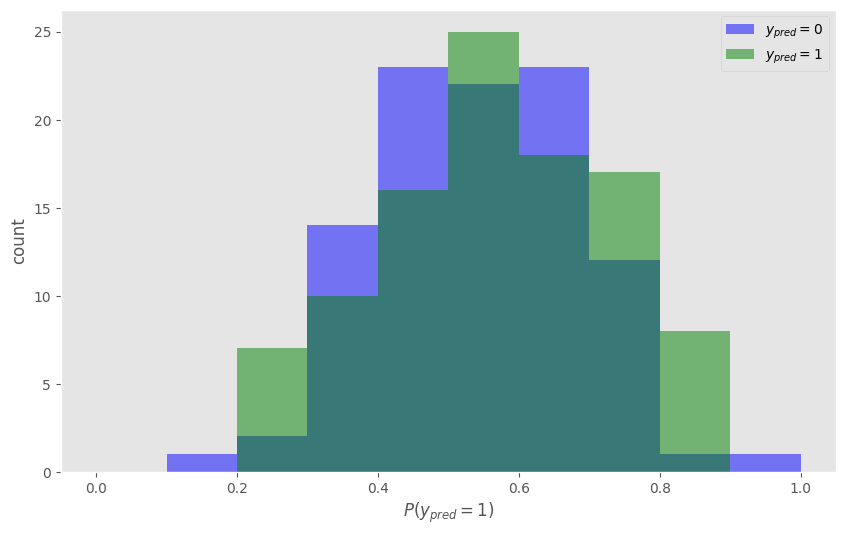

In [34]:
table = np.hstack((y_prob1.reshape((-1,1)), y_test.reshape((-1,1))))
zero_pred = table[table[:,1]==0]
ones_pred = table[table[:,1]==1]
plt.hist(zero_pred[:,0], bins=[round(i/10,1) for i in range(11)], color='blue', alpha=0.5, label='$y_{pred}=0$')
plt.hist(ones_pred[:,0], bins=[round(i/10,1) for i in range(11)], color='green', alpha=0.5, label='$y_{pred}=1$')
plt.ylabel('count')
plt.xlabel('$P(y_{pred} = 1)$')
plt.legend()
plt.grid()

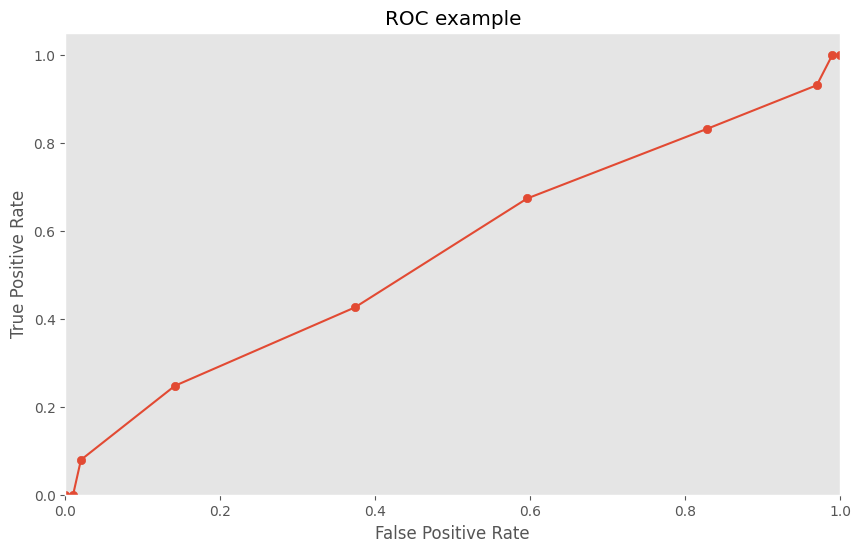

In [35]:
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob1)
plt.figure()
plt.scatter(fpr, tpr)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC example')
plt.grid()
plt.show()

Roc близка к диагонали - это значит, что классификатор распределяет классы не лучше случайно подброшенной монетки. С вероятностью $0.5$ у нас может появиться любой класс. Если ROC-кривая близка к диагонали, это означает, что наш классификатор бесполезен и работает не лучше рандома.


Посмотрим на сетап, где классы могут быть идеально разделены:

In [36]:
np.random.seed(1337)
n = 1000
a = np.random.normal(loc=0, scale=0.7, size=(n, 2)) #первый класс
b = np.random.normal(loc=5, scale=0.7, size=(n, 2)) #второй класс
X = np.vstack([a, b]) #двумерный количественный признак
y = np.hstack([np.zeros(n), np.ones(n)]) #бинарный признак

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

(1800, 2) (1800,)


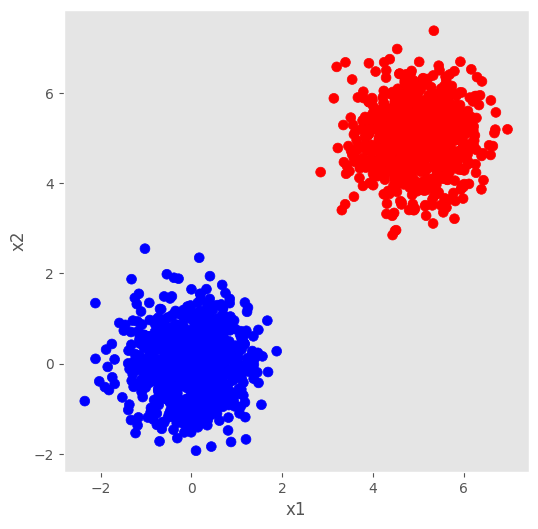

In [37]:
print(X_train.shape, y_train.shape)
plt.figure(figsize=(6, 6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='bwr', s=50, alpha=1)
plt.xlabel('x1')
plt.ylabel('x2')
plt.grid()

In [38]:
model = clf.fit(X_train, y_train)
y_prob = model.predict_proba(X_test)
y_prob1 = y_prob[:,1]

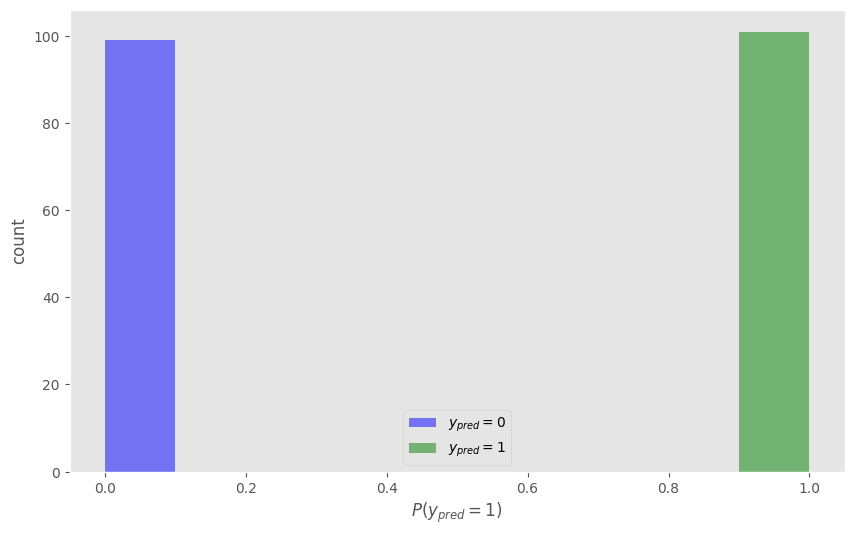

In [39]:
table = np.hstack((y_prob1.reshape((-1,1)), y_test.reshape((-1,1))))
zero_pred = table[table[:,1]==0]
ones_pred = table[table[:,1]==1]
plt.hist(zero_pred[:,0], bins=[round(i/10,1) for i in range(11)], color='blue', alpha=0.5, label='$y_{pred}=0$')
plt.hist(ones_pred[:,0], bins=[round(i/10,1) for i in range(11)], color='green', alpha=0.5, label='$y_{pred}=1$')
plt.ylabel('count')
plt.xlabel('$P(y_{pred} = 1)$')
plt.legend()
plt.grid()

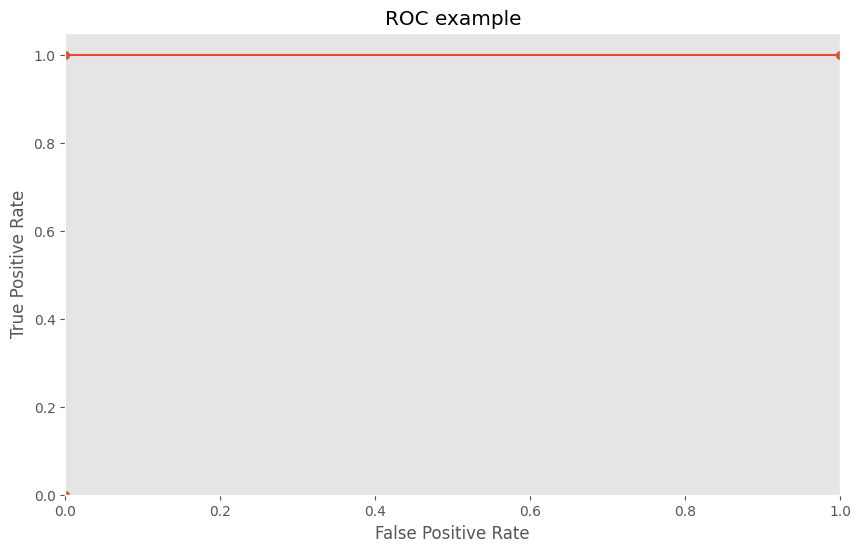

In [40]:
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob1)
plt.figure()
plt.scatter(fpr, tpr)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC example')
plt.grid()
plt.show()

# Метрики регрессии

Для регрессии также существуют свои метрики качества, отличные от уже известных нам MAE и MSE, например коэффициент детерминации:

$$R^2 = 1 - \frac{\sum_{i=1}^{n}(a(x^{(i)}) - y^{(i)}_{real})^2}{\sum_{i=1}^{n}(y^{(i)}_{real} - \overline{y})^2}$$
 $$\overline{y} = \frac{1}{n}\sum_{i=1}^{n}y^{(i)}_{real}$$

Обычно они тоже есть в scikit-learn

In [41]:
y_true = [3, -0.5, 2, 7]
y_pred = [2.5, 0.0, 2, 8]
metrics.r2_score(y_true, y_pred)  

0.9486081370449679

# Многоклассовая классификация

## One vs. One, One vs. Rest
Многоклассовая классификация может быть сведена к бинарной различными способами. 

Подход `One vs. Rest`: для каждого класса $i \in \{1, \dots, k\}$ обучим бинарный классификатор $a_i(x) = sign f_i(x)$ на исходной выборке с изменёнными метками (объекты $i$-го класса получают метку 1, все оставшиеся объекты - метку 0), то есть мы учим $a_i$ отличать $i$-ый класс от всех остальных. После чего итоговый классификатор строится как $a(x) = argmax_{i \in \{1, \dots, k\}} f_i(x)$, то есть он выдаёт класс с наибольшей оценкой $f_i(x)$. 

На деле внутри алгоритмов автоматически вызывается `One vs. Rest`, когда отправляем многоклассовые данные.

Подход `One vs. One`: в этом случае мы берем пару классов $(i,j)$ и для каждой пары обучаем классификатор $f_{i,j}$. Получается мы обучаем $\frac{k(k-1)}{2}$ классификаторов, где $k$ - количество классов. После чего итоговый классификатор выбирается так: перебираем все обученные классификаторы и смотрим за какой класс проголосовало большинство: 
$$a(x) = argmax_{c \in \{1, \dots, k\}}\sum_{i\neq j\in\{1, \dots, k\}} \mathcal{I}(f_{i,j}(x) = c)$$



In [58]:
from sklearn import datasets
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score

iris = datasets.load_iris()
X, y = iris.data[:, :2], iris.target # фичи подрезаны до двух, чтобы нарисовать можно было

SGDClassifier()

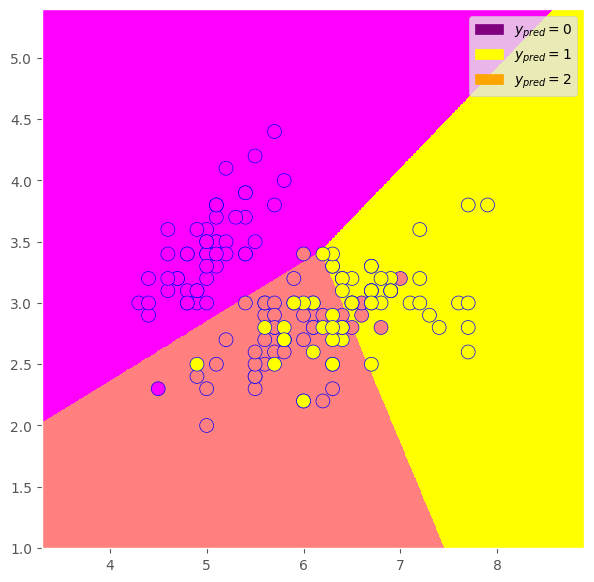

In [54]:
plot_model(X, y, SGDClassifier().fit(X, y))

OneVsRestClassifier(estimator=SGDClassifier())

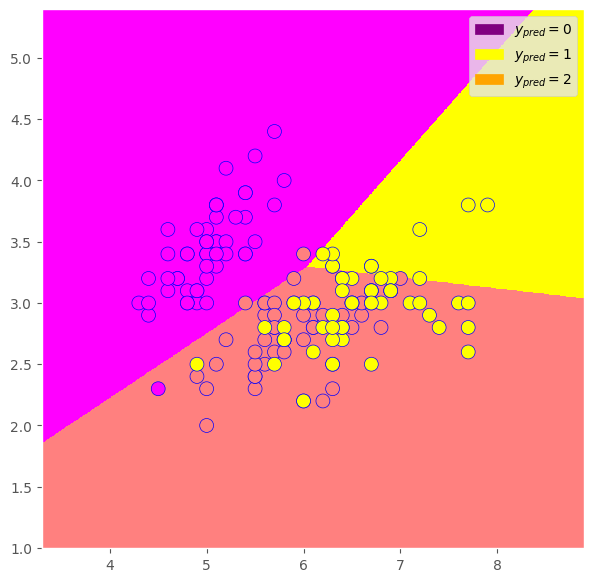

In [55]:
plot_model(X, y, OneVsRestClassifier(SGDClassifier()).fit(X,y))

OneVsOneClassifier(estimator=SGDClassifier())

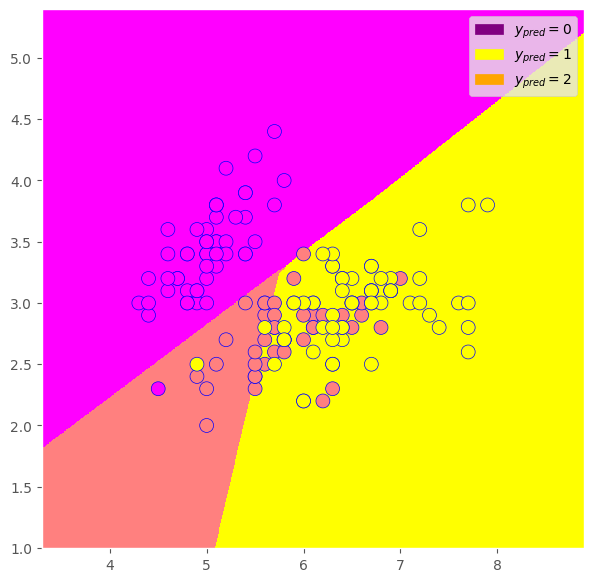

In [56]:
plot_model(X, y, OneVsOneClassifier(SGDClassifier()).fit(X,y))

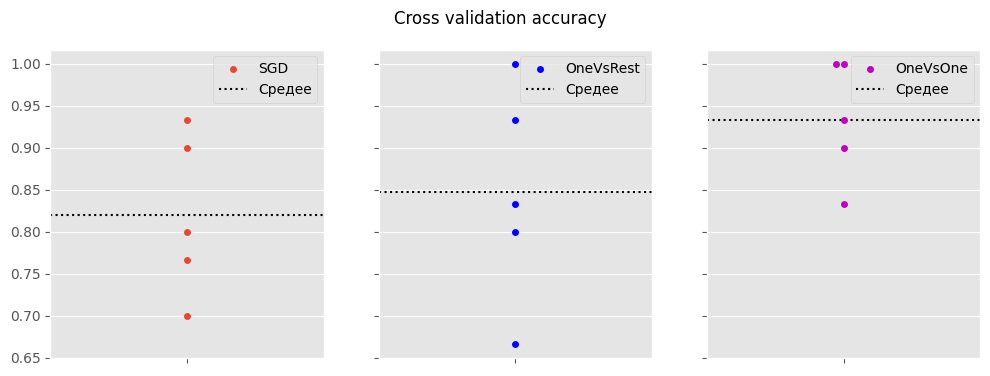

In [93]:
X, y = iris.data, iris.target
np.random.seed(1234)
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
sns.swarmplot(
    scores := cross_val_score(SGDClassifier(), X, y, scoring="accuracy"),
    label="SGD",
    ax=axes[0],
)
axes[0].axhline(np.mean(scores), c='k', ls=':', label='Средее')
sns.swarmplot(
    scores := cross_val_score(
        OneVsRestClassifier(SGDClassifier()), X, y, scoring="accuracy"
    ),
    label="OneVsRest",
    ax=axes[1],
    color="b",
)
axes[1].axhline(np.mean(scores), c='k', ls=':', label='Средее')
sns.swarmplot(
    scores := cross_val_score(
        OneVsOneClassifier(SGDClassifier()), X, y, scoring="accuracy"
    ),
    label="OneVsOne",
    ax=axes[2],
    color="m",
)
axes[2].axhline(np.mean(scores), c='k', ls=':', label='Средее')
for ax in axes:
    ax.legend(loc=1)
fig.suptitle('Cross validation accuracy')
plt.show()

## Полезные ссылки:
* [Model Tuning Grid, Random Search](https://www.kaggle.com/willkoehrsen/intro-to-model-tuning-grid-and-random-search)
* [Статья про метрики](https://habrahabr.ru/company/ods/blog/328372/)
* [Roc-auc](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5)
* [Связь AUC-ROC и AUC-PR](http://pages.cs.wisc.edu/~jdavis/davisgoadrichcamera2.pdf) (AUC-PR - площадь под кривой Precision-Recall)
* [Ultimate guide to Binary Classifiction Metrics](https://towardsdatascience.com/the-ultimate-guide-to-binary-classification-metrics-c25c3627dd0a)

- [Статья](http://habrahabr.ru/post/228963/) "Как заставить работать бинарный классификатор чуточку лучше" на Habrahabr
- [ROC-кривая](http://www.machinelearning.ru/wiki/index.php?title=ROC-%D0%BA%D1%80%D0%B8%D0%B2%D0%B0%D1%8F)
- [Характеристики](https://en.wikipedia.org/wiki/Precision_and_recall) бинарного классификатора
- [One vs. All и One vs. One](https://en.wikipedia.org/wiki/Multiclass_classification)
- [Quora](https://www.quora.com/In-classification-how-do-you-handle-an-unbalanced-training-set) про несбаланированные выборки
- про несбаланированные выборки на [ресурсе](http://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/) Machine Learning Mastery
- [Hyperopt example](https://medium.com/district-data-labs/parameter-tuning-with-hyperopt-faa86acdfdce)

## Источники материалов:
* [mlcourse.ai](https://github.com/Yorko/mlcourse.ai) - курс Машинного обучения с OpenDataScience
* [AI Seminars](https://github.com/AICommunityInno/Seminars) - семинары по Машинному обучению в Иннополисе
* [HSE-ML course](https://github.com/esokolov/ml-course-hse) - курс Машинного обучения ФКН ВШЭ